# Essencial of Factor Investing

In [1]:

# === Standard Libraries ===
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error


warnings.filterwarnings("ignore")

### Get Data

In [2]:
start_date = "2010-01-02"
end_date = "2025-11-01"

tickers = ["NVDA","MSFT","AAPL","AMZN","GOOGL","META","AVGO","BRK-B","JPM","LLY","UNH","XOM","JNJ","V","PG","MA","HD","ORCL","COST","BAC","MRK","PFE","WMT",
     "ADBE","CRM","AMD","NFLX","KO","PEP","TMO","ABT","ACN","DHR","MCD","TXN","LIN","PM","NEE","UPS","IBM","INTC","AMAT","CAT","GE","DE","CVX","BLK","CSCO"]

factors = ['MTUM', 'QUAL', 'SIZE', 'USMV', 'VLUE', 'SPY']
asset_data = yf.download(tickers, start=start_date, end=end_date)['Close']
factor_data = yf.download(factors, start=start_date, end=end_date)['Close']

[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  6 of 6 completed


In [3]:
asset_data = asset_data.fillna(method='ffill').dropna()
factor_data = factor_data.fillna(method='ffill').dropna()
asset_return = asset_data.pct_change().dropna()
factor_return = factor_data.pct_change().dropna()

In [4]:
date_to_split = "2021-01-01"

asset_return_insample  = asset_return.loc[:date_to_split]
asset_return_outsample = asset_return.loc[date_to_split:]

factor_return_insample  = factor_return.loc[:date_to_split]
factor_return_outsample = factor_return.loc[date_to_split:]

### Factor Model

### Multi-Factor Model

For each asset *i*, the model is:

$$
R_{i,t} = \alpha_i + \sum_{k=1}^{K} \beta_{i,k} F_{k,t} + \epsilon_{i,t}
$$

Where:

- $R_{i,t}$ : return of asset *i* at time *t*  
- $F_{k,t}$ : return of factor *k* at time *t*  
- $\alpha_i$ : asset-specific intercept  
- $\beta_{i,k}$ : sensitivity (loading) of asset *i* to factor *k*  
- $\epsilon_{i,t}$ : idiosyncratic residual  


---

### Ridge Regression

To estimate the parameters of the multi-factor model, we use **Ridge Regression**, which introduces an L2-penalty to mitigate **multicollinearity** between factors.

Let:

- $\mathbf{R}_i$ be the vector of returns of asset *i*  
- $\mathbf{X}$ be the design matrix (factors + intercept)  
- $\boldsymbol{\theta}_i = (\alpha_i,\ \beta_{i,1},\ldots,\beta_{i,K})^\top$ be the parameter vector  

The **general Ridge objective function** is:

$$
\min_{\boldsymbol{\theta}_i} \;
\|\mathbf{R}_i - \mathbf{X}\boldsymbol{\theta}_i\|_2^2
\;+\;
\lambda \|\boldsymbol{\beta}_i\|_2^2
$$

Where:

- $\lambda \ge 0$ controls the degree of regularization  
- The penalty applies **only to factor loadings** $\boldsymbol{\beta}_i$, not to the intercept  

Expanded form:

$$
\min_{\alpha_i,\ \beta_{i,1},\ldots,\beta_{i,K}}
\Bigg[
\sum_{t=1}^{T}
\left( R_{i,t} - \alpha_i - \sum_{k=1}^{K} \beta_{i,k} F_{k,t} \right)^2
+
\lambda \sum_{k=1}^{K} \beta_{i,k}^2
\Bigg]
$$


In [5]:
class FactorRidgeRegression:
    """
    =====================================================
                     FACTOR RIDGE REGRESSION
    =====================================================
    Performs L2-regularized (Ridge) time-series regressions
    of asset returns on a set of factor returns.

    Ridge regression is especially useful when factors are
    correlated, as it stabilizes coefficient estimates and
    mitigates overfitting.

    For each asset i, we estimate:
        R_i = α + β₁F₁ + β₂F₂ + ... + βₖFₖ + ε

    Attributes
    ----------
    asset_returns : pd.DataFrame
        (T * N) matrix of asset returns
    factors : pd.DataFrame
        (T * K) matrix of factor returns
    alpha : float
        Ridge regularization strength λ
    results : dict[str, Ridge]
        Fitted models per asset
    summary_df : pd.DataFrame
        Summary table created after run_regressions()
    """

    def __init__(self, asset_returns: pd.DataFrame, factors: pd.DataFrame, alpha: float = 1.0):
        self.asset_returns = asset_returns
        self.factors = factors
        self.alpha = alpha
        self.results = {}

    def run_regressions(self) -> pd.DataFrame:
        aligned_returns = self.asset_returns.dropna()
        aligned_factors = self.factors.dropna()
        common_index = aligned_returns.index.intersection(aligned_factors.index)

        Y = aligned_returns.loc[common_index]
        X = aligned_factors.loc[common_index]

        Xc = np.column_stack([np.ones(len(X)), X.values])
        factor_names = ["const"] + list(X.columns)

        alpha_grid = {"alpha": np.logspace(-2, 2, 50)}

        summary_data = []

        for asset in Y.columns:
            y = Y[asset].values
            
            ridge = Ridge(fit_intercept=False)
            search = GridSearchCV(ridge, alpha_grid, cv=5)
            search.fit(Xc, y)

            model = search.best_estimator_
            best_alpha = search.best_params_["alpha"]

            y_pred = model.predict(Xc)
            r2 = r2_score(y, y_pred)
            mse = mean_squared_error(y, y_pred)

            coefs = dict(zip(factor_names, model.coef_))

            row = {
                "Asset": asset,
                **coefs,
                "Best Alpha": best_alpha,
                "R-squared": r2,
                "MSE": mse
            }

            summary_data.append(row)
            self.results[asset] = model

        self.summary_df = pd.DataFrame(summary_data).set_index("Asset")
        return self.summary_df


    def get_summary(self) -> pd.DataFrame:
        if hasattr(self, "summary_df"):
            return self.summary_df
        else:
            raise ValueError("Run regressions first.")

In [6]:

def compute_metrics(series):
    """
    Retourne:
    - cumulative return
    - annualized volatility
    - sharpe
    - max drawdown
    """
    cumret = (1 + series).prod() - 1
    vol = series.std() * np.sqrt(252)
    sharpe = series.mean() / series.std() * np.sqrt(252)

    equity = (1 + series).cumprod()
    dd = equity / equity.cummax() - 1
    maxdd = dd.min()

    return pd.Series({
        "Cumulative Return": cumret,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": maxdd
    })


In [7]:
regressor = FactorRidgeRegression(asset_returns=asset_return_insample, factors=factor_return_insample)
summary_table = regressor.run_regressions()
pd.set_option("display.max_columns", None)
summary_table.round(4)


,const,MTUM,QUAL,SIZE,SPY,USMV,VLUE,Best Alpha,R-squared,MSE
Asset,,,,,,,,,,
AAPL,0.0007,0.4491,0.6029,-0.0900,0.7348,-0.5825,-0.1017,0.0100,0.5350,0.0001
ABT,0.0002,0.3156,0.2009,-0.0528,0.2126,0.3143,0.0047,0.0256,0.5308,0.0001
ACN,0.0002,0.1715,0.3710,0.0973,0.2069,0.2876,-0.0180,0.0100,0.6337,0.0001
ADBE,0.0006,1.0504,0.1454,-0.0848,0.5528,-0.3397,-0.2060,0.0100,0.5838,0.0002
AMAT,0.0004,0.5893,0.1362,0.1367,0.4445,-0.5333,0.5509,0.0100,0.5167,0.0002
AMD,0.0014,1.0940,-0.1039,0.0677,0.7092,-0.8407,0.3139,0.0100,0.2008,0.0011
AMZN,0.0008,1.0640,0.0771,-0.2973,0.9478,-0.7446,-0.2413,0.0100,0.4666,0.0002
AVGO,0.0009,0.5182,0.2373,0.0976,0.6655,-0.5986,0.2519,0.0100,0.4323,0.0003
BAC,0.0001,-0.3865,0.2450,0.1149,0.7513,-0.3668,0.8993,0.0100,0.6675,0.0001


### Building Portfolio with factors

In [8]:
factor_betas = summary_table["SIZE"]
top10_assets = factor_betas.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 assets (Size exposure):")
print(top10_assets)
returns_top10 = asset_return_outsample[top10_assets]

Top 10 assets (Size exposure):
['DE', 'GE', 'CVX', 'MCD', 'HD', 'XOM', 'AMAT', 'JPM', 'PM', 'BAC']


In [9]:
# Equal Weight
w_eq = np.repeat(1 / len(top10_assets), len(top10_assets))
w_eq = pd.Series(w_eq, index=top10_assets)

# Exposure-Based (proportionnel au bêta MTUM)
betas = factor_betas[top10_assets]
betas_pos = betas.clip(lower=0)
w_expo = betas_pos / betas_pos.sum()

print("\nEqual-Weight Weights:")
print(w_eq)

print("\nExposure-Based Weights:")
print(w_expo)


Equal-Weight Weights:
DE      0.1
GE      0.1
CVX     0.1
MCD     0.1
HD      0.1
XOM     0.1
AMAT    0.1
JPM     0.1
PM      0.1
BAC     0.1
dtype: float64

Exposure-Based Weights:
Asset
DE      0.157993
GE      0.145649
CVX     0.137963
MCD     0.100582
HD      0.089373
XOM     0.084916
AMAT    0.079835
JPM     0.068341
PM      0.068284
BAC     0.067064
Name: SIZE, dtype: float64


In [10]:
# Equal Weight Portfolio
port_eq = (returns_top10 * w_eq).sum(axis=1)

# Exposure-Based Portfolio 
port_expo = (returns_top10.mul(w_expo, axis=1)).sum(axis=1)

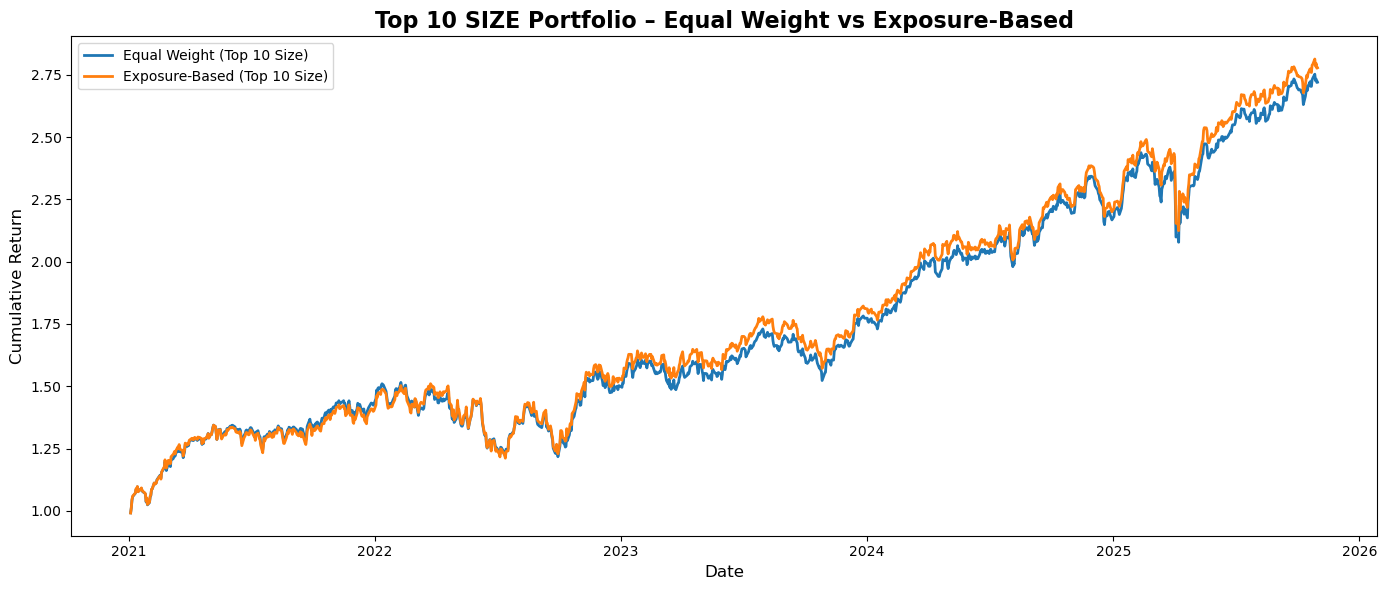

In [11]:
plt.figure(figsize=(14, 6))

plt.plot((1 + port_eq).cumprod(), label="Equal Weight (Top 10 Size)", linewidth=2)
plt.plot((1 + port_expo).cumprod(), label="Exposure-Based (Top 10 Size)", linewidth=2)

plt.title("Top 10 SIZE Portfolio – Equal Weight vs Exposure-Based", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
#plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('Size Top 10 Portfolio.png')
plt.show()


In [12]:
metrics_eq = compute_metrics(port_eq)
metrics_expo = compute_metrics(port_expo)

print("\n=== Equal Weight Metrics ===")
print(metrics_eq.round(4))

print("\n=== Exposure-Based Metrics ===")
print(metrics_expo.round(4))


=== Equal Weight Metrics ===
Cumulative Return    1.7199
Volatility           0.1722
Sharpe               1.2929
Max Drawdown        -0.1967
dtype: float64

=== Exposure-Based Metrics ===
Cumulative Return    1.7776
Volatility           0.1759
Sharpe               1.2941
Max Drawdown        -0.1979
dtype: float64
